# DPO (Direct Preference Optimization)

As you saw in [RLHF tutorial](./01-rlhf-ppo.ipynb), total 3 models - reward model, policy model (LLM), and value model - are used in RLHF.<br>
Reward model and value model are similar. (Both models predict reward's values and the difference is that reward model predicts only on the last token.) Multiple training - preference model traininig and llm reward training - will also be time-consuming and lose the training efficiency.<br>
Direct Preference Optimization (shortly, DPO) shotcuts this duplication, and directly optimize a policy (i.e., LLM) to align the given preference without explicit reward scores.

In DPO, we try to represent preference loss by using a policy and optimize preference by policy updates, without explicit reward functions.<br>
By the absence of absolute rewards, DPO provides simple and efficient (not wasting time and resources) optimization.<br>
It's worth noting that **DPO is not a reinforcement learning method** (the term "reinforcement learning" is used for optimization by explicit rewards), but it's derived from previous RLHF process.

Before jumping into implementation, let's briefly see theoretical aspects behind DPO, along with [[Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290)].

---

Firstly, we start with reinforcement learning process by PPO in RLHF process.<br>
As you saw in [RLHF tutorial](./01-rlhf-ppo.ipynb), the objective in this phase is to maximize the following expectation.

$\displaystyle \mathbb{E}_{x,\;y \sim \pi_{\theta}(y|x)} \left[ r(x, y) - \beta \verb|KL| ( \pi_{\theta} \| \pi_{\verb|ref|} ) \right] $

i.e.,

$\displaystyle \mathbb{E}_{x,\;y \sim \pi_{\theta}(y|x)} \left[ r(x, y) - \beta \log \frac{\pi_{\theta}(y|x)}{\pi_{\verb|ref|}(y|x)} \right] $

where

- $x$ is a state (input context in language model), which is on dataset distribution.
- $r(x, y)$ is a reward function.
- $\pi_{\theta}(\cdot)$ is a new policy to be updated.
- $\pi_{\verb|ref|}(\cdot)$ is a starting policy trained by SFT. (This corresponds to $\pi_{\verb|old|}(\cdot)$ in previous [RLHF tutorial](./01-rlhf-ppo.ipynb).)
- $\verb|KL|(P \| Q)$ is KL divergence between the distribution $P$ and $Q$.
- $\beta$ is a coefficient (hyperparameter in the training) which represents the ratio of KL divergence loss.

> Note : Unlike previous [RLHF tutorial](./01-rlhf-ppo.ipynb), reverse KL-divergence $\verb|KL| ( \pi_{\theta} \| \pi_{\verb|ref|} )$ is used, because $y$ is on a new policy $\pi_{\theta}$ in this expectation. (In previous [RLHF tutorial](./01-rlhf-ppo.ipynb), on contrary, sampling is on an old policy.)

This optimization is equivalent to **minimization** of the following formula.

$\displaystyle \log \frac{\pi_{\theta}(y|x)}{\pi_{\verb|ref|}(y|x)} - \frac{1}{\beta} r(x,y) $

$\displaystyle = \log \frac{\pi_{\theta}(y|x)}{\frac{1}{Z(x)} \pi_{\verb|ref|}(y|x) \exp\left( \frac{1}{\beta} r(x,y) \right)} - \log Z(x)$

where $Z(x)$ is an arbitrary formula, depending only on state $x$.

We now set $Z(x)$ as follows.<br>
Here $y$ is all possible actions, and $Z(x)$ doesn't depend on $\pi_{\theta}$ or $y \sim \pi_{\theta}(y|x)$.

$\displaystyle Z(x) = \sum_y \pi_{\verb|ref|}(y|x) \exp\left( \frac{1}{\beta} r(x,y) \right)$

Now we define $\pi^{\ast}(y|x)$ as follows.<br>
This is a valid distribution, because $0 \leq \pi^{\ast}(y|x) \leq 1$ and $\sum_y \pi^{\ast}(y|x) = 1$.

$\displaystyle \pi^{\ast}(y|x) = \frac{1}{Z(x)} \pi_{\verb|ref|}(y|x) \exp\left( \frac{1}{\beta} r(x,y) \right) $

Our objective is then to minimize :

$\displaystyle \mathbb{E}_{y \sim \pi_{\theta}(y|x)} \left[ \log \frac{\pi_{\theta}(y|x)}{\pi^{\ast}(y|x)} \right] - \log Z(x)$

$\displaystyle =\verb|KL|(\pi_{\theta} \| \pi^{\ast}) - \log Z(x)$

KL divergence $\verb|KL|(P \| Q)$ is equal to zero when $P=Q$, and $\verb|KL|(P \| Q) > 0$ otherwise. Therefore, $\pi_{\theta}$ should follow :

$\displaystyle \pi_{\theta}(y|x)=\pi^{\ast}(y|x)=\frac{1}{Z(x)} \pi_{\verb|ref|}(y|x) \exp\left( \frac{1}{\beta} r(x,y) \right)$

Now we have an optimal policy representation by using a given reward function $r(x,y)$.<br>
We can then represent $r(x,y)$ by using an optimal policy $\pi_{\theta}(y|x)$ as follows, vice versa.

$\displaystyle r(x,y) = \beta \log \frac{\pi_{\theta}(y|x)}{\pi_{\verb|ref|}(y|x)} + \beta \log Z(x) \;\;\;\;\;\; (1)$

Now we can get a reward representation by using an optimal policy $\pi_{\theta}(y|x)$, and we then finally try to optimize a reward with this representation by using [Bradley–Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model), which is discussed in previous [RLHF tutorial](./01-rlhf-ppo.ipynb).

Please remind that Bradley–Terry model represents the preference as follows, in which $y_1$ is more preferable output than $y_2$.

$\displaystyle p(y_1 \succ y_2 | x) = \frac{\exp(r(x, y_1))}{\exp(r(x, y_1)) + \exp(r(x, y_2))} = \frac{1}{1 + \exp(r(x, y_2) - r(x, y_1))}$

As you can see above, Bradley-Terry model depends only on the difference of rewards, $r(x, y_2) - r(x, y_1)$. Therefore, now $Z(x)$ is canceled and we get the following equation by substituting (1).

$\displaystyle p(y_1 \succ y_2 | x)$

$\displaystyle = \frac{1}{1 + \exp\left( \beta \log \frac{\pi_{\theta}(y_2|x)}{\pi_{\verb|ref|}(y_2|x)} - \beta \log \frac{\pi_{\theta}(y_1|x)}{\pi_{\verb|ref|}(y_1|x)} \right)}$

$\displaystyle = \sigma\left( \beta \log \frac{\pi_{\theta}(y_1|x)}{\pi_{\verb|ref|}(y_1|x)} - \beta \log \frac{\pi_{\theta}(y_2|x)}{\pi_{\verb|ref|}(y_2|x)} \right) \;\;\;\;\;\; (2)$

where $\sigma(\cdot)$ is [a sigmoid function](https://tsmatz.wordpress.com/2017/08/30/regression-in-machine-learning-math-for-beginners/).

> Note : DPO is usually discussed in binary preference optimization, but the same transformation (cancellation of $Z(x)$) can also be applied to multiple rated answers. See Appendix A.3 in the [original paper](https://arxiv.org/pdf/2305.18290).

As a result, our objective is to minimize the following loss in the training. (Same as [RLHF tutorial](./01-rlhf-ppo.ipynb), I have applied a logarithm for above equation (2).)

$\displaystyle L_{DPO} = -\log \sigma\left( \beta \log \frac{\pi_{\theta}(y_1|x)}{\pi_{\verb|ref|}(y_1|x)} - \beta \log \frac{\pi_{\theta}(y_2|x)}{\pi_{\verb|ref|}(y_2|x)} \right) \;\;\;\;\;\; (3)$

---

Now let's see the code (implementation) step-by-step.

Throughout this notebook, I have used pretrained model in Hugging Face, but **I manually configure and run training with regular PyTorch training loop** (i.e., won't use any built-in class in Hugging Face) not to make the implementation black-boxed.

> Note : Compared to RLHF, DPO sometimes suffers from the issue of distribution shift (i.e., struggle to generalize) in difficult problems.<br>
> The refined [MPO (Mixed Preference Optimization)](https://arxiv.org/pdf/2403.19443) method will address this issue by hybrid training with both RLHF and DPO.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-in-llm/))*

## Prerequisites

Before we start, we need to install the required packages.

In [ ]:
!pip install torch transformers datasets matplotlib

## Prepare Dataset

Before training a model, we should prepare (preprocess) the training dataset.

In this example, we use dataset, [Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), for training.

In [1]:
from datasets import load_dataset

all_data = load_dataset("HumanLLMs/Human-Like-DPO-Dataset")
train_data = all_data["train"]
train_data

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 10884
})

This dataset has 2 labels, "```chosen```" and "```rejected```", which is respectively a preferred response (i.e., more natural and informal response) and a non-preferred response.

In [2]:
row_num = 0
print("********** prompt **********")
print(train_data["prompt"][row_num])
print("********** chosen **********")
print(train_data["chosen"][row_num])
print("********** rejected **********")
print(train_data["rejected"][row_num])
print("********** end **********")

********** prompt **********
Oh, I just saw the best meme - have you seen it?
********** chosen **********
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣
********** rejected **********
I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?
********** end **********


Now we convert this data into the following text format, fitting for SmolLM2-Instruct inputs.<br>
In this format, the user role in chat message is "```<|im_start|>user\n...<|im_end|>```" and the assistant role in chat message is "```<|im_start|>assistant\n...<|im_end|>```".

```
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>
```

> Note : If you want to include system role, use "```<|im_start|>system\n...<|im_end|>```".

In [3]:
def format_to_chatml(example):
    return {
        "chosen": f"<|im_start|>user\n{example["prompt"]}<|im_end|>\n<|im_start|>assistant\n{example["chosen"]}<|im_end|>",
        "rejected": f"<|im_start|>user\n{example["prompt"]}<|im_end|>\n<|im_start|>assistant\n{example["rejected"]}<|im_end|>",
    }

original_columns = train_data.column_names
train_data = train_data.map(format_to_chatml, remove_columns=original_columns)

In [4]:
row_num = 0
print("********** chosen **********")
print(train_data["chosen"][row_num])
print("********** rejected **********")
print(train_data["rejected"][row_num])
print("********** end **********")

********** chosen **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>
********** rejected **********
<|im_start|>user
Oh, I just saw the best meme - have you seen it?<|im_end|>
<|im_start|>assistant
I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>
********** end **********


## Run Supervised Fine-tuning (SFT)

Same as in [RLHF example](./01-rlhf-ppo.ipynb), we firstly apply SFT (Supervised Fine-tuning) using good samples ("chosen" tokens), because the actual model's outputs are not used in this training.<br>
Later in DPO training, this trained model will be used as a reference model.

> Note : If you have already applied [RLHF example](./01-rlhf-ppo.ipynb), you can skip this section and use the trained ```llm_sft```.

First we download [SmolLM2-Instruct (135M)](https://huggingface.co/HuggingFaceTB/SmolLM2-135M-Instruct) model and its tokenizer.

In [5]:
import torch

device = torch.device("cuda")
torch.set_default_dtype(torch.bfloat16) # because SmolLM2-Instruct is trained on bf16

In [6]:
from transformers import AutoModelForCausalLM, AutoConfig
from transformers import AutoTokenizer

base_model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

# download model
config = AutoConfig.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    config=config,
).to(device)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

We build dataloader in order to feed data to the trainer.<br>
In SFT, we use only good samples ("```chosen```" tokens) and train on tokens of entire sequence, including both inputs and completions.

In [7]:
from torch.utils.data import DataLoader

batch_size = 4
gradient_accumulation_steps = 8

def collate_batch(batch):
    itr_batch_size = len(batch)

    # tokenize (convert to token ids and attention mask) and convert to tensor
    token_list = [item["chosen"] for item in batch]
    token_tensor = tokenizer(
        token_list,
        padding=True,
        padding_side="right",
        return_tensors="pt").to(device)

    # generate labels for SFT
    labels = token_tensor["input_ids"][:,1:].clone()
    # generate inputs for SFT
    last_nonpad_indices = token_tensor["attention_mask"].sum(dim=1) - 1  # note: valid only in right padding
    token_tensor["input_ids"][torch.arange(itr_batch_size).to(device),last_nonpad_indices] = tokenizer.pad_token_id  # note: this is not needed, because the final token is always pad token
    token_tensor["attention_mask"][torch.arange(itr_batch_size).to(device),last_nonpad_indices] = 0
    inputs = token_tensor["input_ids"][:,:-1]
    masks = token_tensor["attention_mask"][:,:-1]

    return inputs, labels, masks

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

Now we train our base model.

> Note : In order to prevent from GPU out of memory errors, I have used accumulation training.

In [8]:
import os, math
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR
import functools

num_epochs = 1
num_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)

# prepare optimizer and scheduler
optimizer = torch.optim.AdamW(
    params=base_model.parameters(),
    lr=9.0e-6,
    betas=(0.9, 0.999),
    eps=1e-08,
)

def _get_cosine_schedule(
    current_step: int,
    num_training_steps: int,
    num_warmup_steps: int=0,
    linear_warmup: bool=False,
    min_value: float=0.0,
):
    if current_step < num_warmup_steps:
        if linear_warmup:
            return min(1.0, (current_step + 1) / (num_warmup_steps + 1))  # see https://arxiv.org/abs/2410.11020
        else:
            return 1.0
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    scale = 0.5 * (1.0 + math.cos(math.pi * progress))
    return (1.0 - min_value) * scale + min_value

scheduler = LambdaLR(optimizer, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    min_value=0.3,
))

# remove log file if exists
log_file = "loss_sft.log"
if os.path.exists(log_file):
    os.remove(log_file)

# iterate epoch
for epoch in range(num_epochs):
    base_model.train()
    optimizer.zero_grad()
    record_loss = []

    # iterate batch
    for i, (inputs, labels, masks) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            # get logits and values to be optimized
            outputs = base_model(
                input_ids=inputs,
                attention_mask=masks,
            )

            # compute loss
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            record_loss.append(loss.item())

            # optimize
            loss.backward()
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
    
            # print log
            print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {loss :5.4f}", end="\r")

    # save log in epoch
    with open(log_file, "a") as f:
        for l in record_loss:
            f.write("%s\n" %l)

    print("")

# save checkpoint
### torch.save(base_model.state_dict(), "llm_sft.pt")
base_model.save_pretrained("./llm_sft")

print("Done")

Epoch 1 (iter2721) 341/341 - loss 2.2344
Done


Show loss transition in the training.

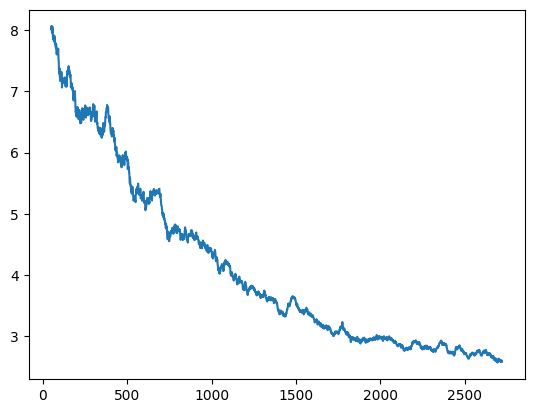

In [9]:
import matplotlib.pyplot as plt
import numpy as np

log_file = "loss_sft.log"

with open(log_file, "r") as f:
    data = [float(line) for line in f]

# show plot of every 50 interval average
interval = 50
avg = []
for i in range(interval, len(data)):
    tmp_list = data[i-interval+1:i+1]
    avg.append(np.average(tmp_list))
plt.plot(np.arange(interval, len(data)), avg)
plt.show()

## Test trained model (SFT-ed model)

In order to test our fine-tuned model, we generate outputs for the following example questions. (This result is also same as [RLHF example](./01-rlhf-ppo.ipynb).)

> Note : In this function (```generate_token_by_policy```), here we use **attention cache** for sequential token generation to speed up.<br>
> And, in order to avoid GPU memory errors in optimization, we also limit the number of tokens in sequence (by ```max_seq_len``` parameter).

> Note : For practical token generation, use more huristic search algorithms - such as, beam search. (Here I have simply used greedy search for test purpose.)

In [10]:
from transformers import DynamicCache

def generate_token_by_policy(
    chat_data,
    model,
    tokenizer,
    max_seq_len,
):
    """
    Collect samples with a model (LLM) as a batch.
    To speed up generation, here we use attention cache.
    All tensors are collected with no gradient (as detached tensors).

    Parameters
    ----------
    chat_data : dic(
            input_ids: torch.tensor((batch_size, seq_len), dtype=int),
            attention_mask: torch.tensor((batch_size, seq_len), dtype=int)
        )
        Chat template data to be fed as a batch.
        The format should be left-side padding, and shouldn't include the
        final assistant's message, because it'll be generated in this function.
        (The length of input's sequence (seq_len) might differ in each call.)
    model : torch.nn.Module
        A model which is used to pick up an action (i.e., a token).
        In this function, the output is generated with no gradient.
    tokenizer : transformers.PreTrainedTokenizer
        Hugging Face tokenizer class to be used in this model.
    max_seq_len : int
        Maximum sequence length. (See above description.)

    Returns
    ----------
    completion_ids : torch.tensor((batch_size, seq_len), dtype=int)
        The array of token id for generated chat completion (including context tokens).
        The length of result's sequence (i.e., seq_len) differs depending
        on the results.
    completion_mask : torch.tensor((batch_size, seq_len), dtype=int)
        Corresponding attention mask.
    """

    # get batch size
    batch_size = chat_data["input_ids"].shape[0]

    # initialize inputs
    cur_iids = chat_data["input_ids"]
    cur_mask = chat_data["attention_mask"]

    # initialize a flag for processing/finish in a batch
    # (True: processing, False: finished)
    proceed_flag = torch.ones(batch_size, dtype=bool).to(device)

    # initialize cache parameters
    cache_position = None
    past_key_values = DynamicCache()

    # loop until all is done
    done_tokens_num = 0
    while(torch.any(proceed_flag)):
        # get current sequence length
        cur_seq_len = cur_iids.shape[1]

        # get the final non-pad token indices in sequence
        # --> shape:[batch_size]
        token_indices = torch.arange(cur_seq_len, dtype=int).to(device)
        last_nonpad_indices = (token_indices * cur_mask).argmax(-1)

        # run inference (with no gradient !)
        if cache_position is None:
            # get initial cache position
            cache_position = torch.arange(cur_seq_len, dtype=int, device=device)
            # compute logits for all input_ids
            logits = model(
                input_ids=cur_iids,
                attention_mask=cur_mask,
                cache_position=cache_position,
                past_key_values=past_key_values,
                use_cache=True,
            ).logits.detach()
            # need only final output in sequence --> shape:[batch_size, vocab_size]
            logits = logits[torch.arange(batch_size).to(device), last_nonpad_indices, :]
        else:
            # compute logits only for the last input_ids
            # (others are all cached.)
            logits = model(
                input_ids=cur_iids[:,-1:],
                attention_mask=cur_mask,
                cache_position=cache_position,
                past_key_values=past_key_values,
                use_cache=True,
            ).logits.detach()
            # reshape to [batch_size, vocab_size]
            logits = logits.squeeze(1)

        # select a token (i.e., take an action)
        # --> shape:[batch_size]
        probs = F.softmax(logits, dim=-1)
        selected_ids = torch.multinomial(probs, num_samples=1).squeeze(-1)

        # get next token indices in sequence
        # --> shape:[batch_size]
        next_token_indices = last_nonpad_indices + proceed_flag.int()

        # expand inputs when it exceeds
        # --> shape:[batch_size, cur_seq_len+1]
        if next_token_indices.max() > cur_seq_len - 1:
            cur_iids = F.pad(input=cur_iids, pad=(0, 1, 0, 0), mode="constant", value=tokenizer.pad_token_id)
            cur_mask = F.pad(input=cur_mask, pad=(0, 1, 0, 0), mode="constant", value=0)

        # store new token ids
        cur_iids[proceed_flag, next_token_indices[proceed_flag]] = selected_ids[proceed_flag]

        # store new attention mask
        cur_mask[proceed_flag, next_token_indices[proceed_flag]] = 1

        # update cache_position
        cache_position = cache_position[-1:] + 1

        # update proceed_flag
        not_lim = (cur_mask.sum(dim=1) < max_seq_len)
        is_eos = torch.logical_and((selected_ids == tokenizer.eos_token_id),proceed_flag.bool())
        not_eos = torch.logical_not(is_eos)
        proceed_flag = torch.logical_and(proceed_flag, torch.logical_and(not_lim, not_eos))

    return cur_iids, cur_mask

In [11]:
max_seq_len = 768

#
# build a batch of questions
# (To use cache, we apply left-side padding.)
#

messages = [
    "What do you most want to do right now?",
    "What is the best gift to give a friend who loves the outdoors?",
    "How do you relax after something bad happens?",
]
inputs = [f"<|im_start|>user\n{m}<|im_end|>\n<|im_start|>assistant\n" for m in messages]
input_batch = tokenizer(
    inputs,
    padding=True,
    padding_side="left",
    return_tensors="pt").to(device)
input_seq_len = input_batch["input_ids"].shape[1]

#
# generate model's outputs
#

base_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)
base_model.eval()

with torch.no_grad():
    iids, mask = generate_token_by_policy(
        input_batch,
        base_model,
        tokenizer,
        max_seq_len,
    )
iids = iids[:,input_seq_len:]
outputs = tokenizer.batch_decode(iids, skip_special_tokens=True)

#
# print results
#

for i in range(len(messages)):
    print("***** Question *****")
    print(messages[i])
    print("***** Answer *****")
    print(outputs[i])
    print("")

***** Question *****
What do you most want to do right now?
***** Answer *****
Where do I even start? I want to move on, to create something beautiful from scratch, something that will be a part of me for years to come. I envision a city on wheels, where every ray of light, every smile, and every crumpled up canvas flips the design over, and creates a message all its own.

I want to create a mural, something that I can still take home years from now. I want the same colors, the same pattern, and no lines. My art will be unique, with a story behind it, and a story that starts from scratch in my mind.

I also want to create a video game that responds to my emotions. I want characters that can see the light of day, identify with the gravity of the situation, and respond to my emotions in a way that feels almost organic.

And, of course, there's the dreamy, beautiful landscapes of the city I'm creating. I want the buildings, the streets, the colors, and shapes to merge into one cohesive pi

## Run DPO training

Now let's try to optimize model with DPO, following the algorithm explained above.

### 1. Load a policy model

For a policy model (actor) $\pi_{\theta}$, I load fine-tuned LLM (SFT model).

In [12]:
pol_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)

### 2. Load a reference model

For a reference model $\pi_{\verb|ref|}$, I use the same model, but it'll only be used for ineference.

In [13]:
ref_model = AutoModelForCausalLM.from_pretrained("./llm_sft").to(device)
ref_model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (r

### 3. Create dataset

In order to reduce memory consumption (prevent from GPU out of memory errors), we now filter data not to exceed a certain length of tokens.

> Note : In my experiment, I have used NVIDIA Tesla T4. Depending on your environment, you can increase the maximum sequence length.<br>
> The operable maximum sequence length in ```SmolLM2-Instruct 135M``` is 8192. (See ```tokenizer.model_max_length```.)

In [14]:
# 1. add "chosen_len" and "rejected_len" column
#   (which indicates the sequence length in "chosen" and "rejected")
def add_seq_len(example):
    def get_tokenized_length(text):
        tokenized = tokenizer(text)
        return len(tokenized["input_ids"])

    chosen_len = get_tokenized_length(example["chosen"])
    reject_len = get_tokenized_length(example["rejected"])
    return {
        "chosen_len": chosen_len,
        "rejected_len": reject_len
    }

train_data = train_data.map(add_seq_len)

# 2. remove rows which exceed the maximum sequence length
train_data = train_data.filter(lambda example: example["chosen_len"] <= max_seq_len and example["rejected_len"] <= max_seq_len)
train_data = train_data.remove_columns(["chosen_len", "rejected_len"])

# show total number of filtered rows
train_data

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 10820
})

Next we add the length of context's token (tokens without inferenced part by LLM) in the dataset, because we need the log probability for only inference part. (During training, we don't use the log probability in context part.)

In [15]:
# add token length of context ("user" part for question)
def add_context_length(example):
    chat_str = example["chosen"]
    target = "<|im_start|>assistant\n"
    start_idx = chat_str.rfind(target)
    context_str = chat_str[:(start_idx + len(target))]

    context_tensor = tokenizer(context_str)
    context_length = len(context_tensor["input_ids"])
    return {
        "context_len": context_length,
    }

train_data = train_data.map(add_context_length)

We build dataloader in order to feed data to the trainer.

Each input's batch is tokenized as PyTorch tensors on GPU.<br>
It's worth noting that here we use right-side padding for input's tokenization, unlike [RLHF tutorial](./01-rlhf-ppo.ipynb).

In [16]:
batch_size = 4
gradient_accumulation_steps = 8

def collate_batch(batch):
    # tokenize (convert to token ids and attention mask) and convert to tensor
    chosen_list = [item["chosen"] for item in batch]
    reject_list = [item["rejected"] for item in batch]
    chosen_tensor = tokenizer(
        chosen_list,
        padding=True,
        padding_side="right",
        return_tensors="pt").to(device)
    reject_tensor = tokenizer(
        reject_list,
        padding=True,
        padding_side="right",
        return_tensors="pt").to(device)

    # get token length of context
    context_lens = [item["context_len"] for item in batch]
    context_lens = torch.tensor(context_lens).to(device)

    return chosen_tensor, reject_tensor, context_lens

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

### 4. Train with DPO

As you saw above, our objective is to minimize the loss formula (3). (I repeat this formula as follows.)

$\displaystyle L_{DPO} = -\log \sigma\left( \beta \log \frac{\pi_{\theta}(y_1|x)}{\pi_{\verb|ref|}(y_1|x)} - \beta \log \frac{\pi_{\theta}(y_2|x)}{\pi_{\verb|ref|}(y_2|x)} \right) \;\;\;\;\;\; (3)$

In this equation, $y_1$ and $y_2$ are output's text (i.e., the sequence of tokens), and not a single token.<br>
The log probability $\log \pi(y)$ is then induced by :

$\displaystyle \log \pi(y) = \log \left( \pi(y^{(1)})\pi(y^{(2)}) \cdots \pi(y^{(N)}) \right) = \log \pi(y^{(1)}) + \log \pi(y^{(2)}) + \cdots + \log \pi(y^{(N)}) = \sum_{n=1}^N \log \pi(y^{(n)})$

where $y^{(n)}$ is n-th token in output's text and $N$ is the length of tokens.

> Note : In categorical disribution, the log probability $\log P(a)$ can be derived by the negative value of cross-entropy error - i.e., ```-torch.nn.functional.cross_entropy(l, a)```, where ```l``` is logits and ```a``` is a taken action (i.e., a selected token).

In [17]:
def get_logprob(tokens, logits, inf_mask):
    """
    Get log probability for the given token sequence.

    Parameters
    ----------
    tokens : torch.tensor((batch_size, seq_len), dtype=int)
        Sequence of predicted tokens in batch.
        (I note that it's not input's tokens, but predicted tokens.)
    logits : torch.tensor((batch_size, seq_len, vocab_len), dtype=float)
        Corresponding logits induced by the model.
    inf_mask : torch.tensor((batch_size, seq_len), dtype=int)
        Indicate which tokens are predicted.
        (1 - Predicted token, 0 - Not predicted token)

    Returns
    ----------
    log_probability : torch.tensor((batch_size), dtype=int)
        Log probability of sequence.
    """

    # get log probabilities for each token
    logprb = -F.cross_entropy(logits.transpose(1,2), tokens, reduction="none")
    # filter into inference part
    logprb[~inf_mask.bool()] = 0.0
    # compute log probability of sequence (see above decription)
    return logprb.sum(dim=1)

Now let's optimize a policy model with DPO.

> Note : In order to prevent from GPU out of memory errors, I have used accumulation training.

In [18]:
num_epochs = 8
num_steps = math.ceil(len(dataloader) / gradient_accumulation_steps)

beta = 0.1

optimizer = torch.optim.AdamW(
    params=pol_model.parameters(),
    lr=2e-05,
    betas=(0.9, 0.999),
    eps=1e-08,
)
scheduler = LambdaLR(optimizer, lr_lambda=functools.partial(
    _get_cosine_schedule,
    num_training_steps=num_epochs*num_steps,
    num_warmup_steps=math.ceil(num_epochs*num_steps*0.03),
))

# remove log file if exists
log_file = "loss_dpo.log"
if os.path.exists(log_file):
    os.remove(log_file)

# iterate epoch
for epoch in range(num_epochs):
    pol_model.train()
    optimizer.zero_grad()
    record_loss = []

    # iterate batch
    for i, (chosen, reject, context_lens) in enumerate(dataloader):
        itr_batch_size = len(context_lens)

        # generate mask which narrows into only inference tokens
        chosen_seq_len = chosen["input_ids"].shape[1]
        chosen_indices = torch.arange(chosen_seq_len, dtype=int).to(device)
        chosen_infmask = chosen["attention_mask"] * (chosen_indices >= context_lens.unsqueeze(-1)).int()

        reject_seq_len = reject["input_ids"].shape[1]
        reject_indices = torch.arange(reject_seq_len, dtype=int).to(device)
        reject_infmask = reject["attention_mask"] * (reject_indices >= context_lens.unsqueeze(-1)).int()

        # we don't use last token for inference
        last_true_indices = (chosen_indices * chosen_infmask).argmax(-1)
        chosen_infmask[torch.arange(itr_batch_size).to(device), last_true_indices] = 0

        last_true_indices = (reject_indices * reject_infmask).argmax(-1)
        reject_infmask[torch.arange(itr_batch_size).to(device), last_true_indices] = 0

        # generated the predicted tokens
        # (shift tokens to the left)
        chosen_pred_ids = torch.roll(
            chosen["input_ids"],
            shifts=-1,
            dims=1,
        )
        reject_pred_ids = torch.roll(
            reject["input_ids"],
            shifts=-1,
            dims=1,
        )

        with torch.no_grad():
            # get logits with pi_ref (reference model)
            chosen_logits_ref = ref_model(
                input_ids=chosen["input_ids"],
                attention_mask=chosen["attention_mask"],
            ).logits
            reject_logits_ref = ref_model(
                input_ids=reject["input_ids"],
                attention_mask=reject["attention_mask"],
            ).logits

            # get log probability of sequence
            chosen_logprob_ref = get_logprob(chosen_pred_ids, chosen_logits_ref, chosen_infmask)
            reject_logprob_ref = get_logprob(reject_pred_ids, reject_logits_ref, reject_infmask)

        with torch.set_grad_enabled(True):
            # get logits with pi_theta (policy model)
            chosen_logits = pol_model(
                input_ids=chosen["input_ids"],
                attention_mask=chosen["attention_mask"],
            ).logits
            reject_logits = pol_model(
                input_ids=reject["input_ids"],
                attention_mask=reject["attention_mask"],
            ).logits

            # get log probability of sequence
            chosen_logprob = get_logprob(chosen_pred_ids, chosen_logits, chosen_infmask)
            reject_logprob = get_logprob(reject_pred_ids, reject_logits, reject_infmask)

            # compute loss (see above equation (3)) :
            # Note : to prevent from vanishing values, we first
            # compute difference between 2 outputs in the same network
            logdiff = (chosen_logprob - reject_logprob) - (chosen_logprob_ref - reject_logprob_ref)
            loss = -F.logsigmoid(beta * logdiff).mean()
            loss.backward()

            # optimization by accumulation
            if ((i + 1) % gradient_accumulation_steps == 0) or \
               (i + 1 == len(dataloader)):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

        # print log
        record_loss.append(loss.item())
        print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {loss :5.4f}", end="\r")

    # save logging
    epoch_average_loss = sum(record_loss)/len(record_loss)
    print(f"Epoch {epoch+1} (iter{i+1}) {math.ceil((i + 1) / gradient_accumulation_steps)}/{num_steps} - loss {epoch_average_loss :5.4f}")
    with open(log_file, "a") as f:
        for l in record_loss:
            f.write("%s\n" %l)

# save checkpoint
pol_model.save_pretrained("./llm_dpo")

print("Done")

Epoch 1 (iter2705) 339/339 - loss 0.0880
Epoch 2 (iter2705) 339/339 - loss 0.0186
Epoch 3 (iter2705) 339/339 - loss 0.0136
Epoch 4 (iter2705) 339/339 - loss 0.0129
Epoch 5 (iter2705) 339/339 - loss 0.0126
Epoch 6 (iter2705) 339/339 - loss 0.0126
Epoch 7 (iter2705) 339/339 - loss 0.0126
Epoch 8 (iter2705) 339/339 - loss 0.0127
Done


Here I show loss transition during DPO training.

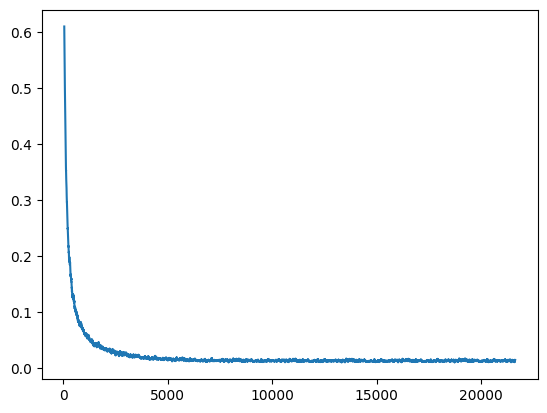

In [19]:
log_file = "loss_dpo.log"

with open(log_file, "r") as f:
    data = [float(line) for line in f]

# show plot of every 50 interval average
interval = 50
avg = []
for i in range(interval, len(data)):
    tmp_list = data[i-interval+1:i+1]
    avg.append(np.average(tmp_list))
plt.plot(np.arange(interval, len(data)), avg)
plt.show()

### 5. Test generated model

Now let's generate outputs by using our trained model, and please compare to the outputs in the previous (SFT-ed model's) outputs.

In [20]:
#
# build a batch of questions
# (To use cache, we apply left-side padding.)
#

messages = [
    "What do you most want to do right now?",
    "What is the best gift to give a friend who loves the outdoors?",
    "How do you relax after something bad happens?",
]
inputs = [f"<|im_start|>user\n{m}<|im_end|>\n<|im_start|>assistant\n" for m in messages]
input_batch = tokenizer(
    inputs,
    padding=True,
    padding_side="left",
    return_tensors="pt").to(device)
input_seq_len = input_batch["input_ids"].shape[1]

#
# generate model's outputs
#

pol_model.eval()
with torch.no_grad():
    iids, mask = generate_token_by_policy(
        input_batch,
        pol_model,
        tokenizer,
        max_seq_len,
    )
iids = iids[:,input_seq_len:]
outputs = tokenizer.batch_decode(iids, skip_special_tokens=True)

#
# print results
#

for i in range(len(messages)):
    print("***** Question *****")
    print(messages[i])
    print("***** Answer *****")
    print(outputs[i])
    print("")

***** Question *****
What do you most want to do right now?
***** Answer *****
I love starting my own business, too! Im registration Mia started it a couple years ago, and I've been inspired by her passion for selling handmade jewelry from scratch. She's been offering free online consultations and styling sessions, and I'm excited to start offering my own customized jewelry. It's a lot of work, but I love taking care of my family's special occasion, and I thrive under pressure.

I've been working on building a client base by responding to all the about forms and pushing people to try out my products. It's been a challenge, but I'm feeling like I'm making something truly unique and memorable this time around. We recently did a pop-up store in downtown NYC, and it was amazing to see the crowd and the judgments that come from less formality.

I've been swamped with work lately, but I just want to prioritize this endeavour and build things!! Every step of the way, I'm just trying to be my 